# COURSE: A deep understanding of deep learning
## SECTION: ANNs
### LECTURE: Model depth vs. breadth
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [31]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision

# Import and organize the data

In [32]:
MNIST = torchvision.datasets.MNIST(".", download=True)
data = MNIST.data
labels = MNIST.targets

# Randomly drop samples to shrink the size to 20,000
np.random.seed(42)  # Set random seed for reproducibility
indices = np.random.choice(len(data), size=20000, replace=False)
data = data[:20000]
labels = labels[:20000]

# Reshape data to 2D array
data = data.reshape(data.shape[0], -1)
# Reshape labels to 2D array
labels = labels.reshape(labels.shape[0], -1)

In [33]:
data_norm = data / torch.max(data)

In [34]:
# convert to tensor
dataT = data_norm.clone().detach().float()
labelsT = labels.clone().detach().long()  # long = int64

# Extract indexes with number 7 
indices_7 = (labels == 7).nonzero(as_tuple=True)[0]
indices_not_7 = (labels != 7).nonzero(as_tuple=True)[0]

# Extract indexes as test data, and the opposite as train data
train_data = dataT.index_select(dim=0, index=indices_not_7)
train_labels = labelsT.index_select(dim=0, index=indices_not_7)
test_data = dataT.index_select(dim=0, index=indices_7)
test_labels = labelsT.index_select(dim=0, index=indices_7)



In [35]:
print(train_data.shape)
print(test_data.shape)

torch.Size([17907, 784])
torch.Size([2093, 784])


In [36]:
# convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize = 32
train_loader_norm = DataLoader(train_data,
                               batch_size=batchsize,
                               shuffle=True,
                               drop_last=True)
test_loader_norm = DataLoader(test_data,
                              batch_size=test_data.tensors[0].shape[0])

# Construct and sanity-check the model

In [37]:
# create a class for the model
def createTheMNISTNet(optimizer_name, learning_rate, num_hidden_layers,
                      num_hidden_units):

    class mnistNet(nn.Module):

        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, num_hidden_units)

            ### hidden layer
            self.fc_layers = [
                nn.Linear(num_hidden_units, num_hidden_units)
                for i in range(0, num_hidden_layers)
            ]

            ### output layer
            self.output = nn.Linear(num_hidden_units, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            for hidden_layer in self.fc_layers:
                x = F.relu(hidden_layer(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer_function = getattr(torch.optim, optimizer_name)
    optimizer = optimizer_function(net.parameters(), lr=learning_rate)

    return net, lossfun, optimizer

In [38]:
# test the model with optimizer type as input
# SGD, RMSprop, Adam
optim = createTheMNISTNet(optimizer_name="RMSprop",
                          learning_rate=.01,
                          num_hidden_layers=2,
                          num_hidden_units=50)[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

# Create a function that trains the model

In [39]:
# a function that trains the model


def function2trainTheModel(train_loader,
                           test_loader,
                           numepochs,
                           optimizer_name,
                           learning_rate,
                           num_hidden_layers=2,
                           num_hidden_units=50):

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet(optimizer_name, learning_rate,
                                                num_hidden_layers,
                                                num_hidden_units)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            y = torch.flatten(y)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
            matchesNumeric = matches.float()  # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
            batchAcc.append(accuracyPct)  # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():
            y = torch.flatten(y)
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean(
            (torch.argmax(yHat, axis=1) == y).float()))

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net


In [40]:
# number of epochs
numepochs = 100
optimizer = "Adam"
learning_rate = .01

print(f"Training with {optimizer} and learning rate {learning_rate}")
train_accuracy_experiment, test_accuracy_experiment, losses_experiment, net_experiment = function2trainTheModel(
    train_loader_norm,
    test_loader_norm,
    numepochs,
    optimizer,
    learning_rate,
    num_hidden_layers=2,
    num_hidden_units=50)
accuracy_experiments = {
    "train_accuracy_experiment": train_accuracy_experiment,
    "test_accuracy_experiment": test_accuracy_experiment
}


Training with Adam and learning rate 0.01


In [41]:
accuracy_experiments

{'train_accuracy_experiment': [87.13663,
  94.26431,
  95.55009,
  96.24888,
  96.61225,
  97.243965,
  97.635284,
  97.81418,
  97.976295,
  98.10487,
  98.429115,
  98.267,
  98.52415,
  98.87075,
  98.63036,
  98.87634,
  99.03846,
  98.7254,
  98.93224,
  98.94343,
  99.27885,
  98.77572,
  99.12791,
  99.463326,
  99.1335,
  99.19499,
  99.37947,
  98.87075,
  99.16704,
  99.58631,
  99.37947,
  99.312386,
  99.28444,
  99.256485,
  99.26766,
  99.597496,
  99.32357,
  99.39624,
  99.3627,
  99.42979,
  99.52482,
  99.30121,
  99.40183,
  99.69253,
  99.41302,
  99.256485,
  99.597496,
  99.58073,
  99.36829,
  99.463326,
  99.40183,
  99.60867,
  99.48569,
  99.44096,
  99.726074,
  99.68694,
  99.37947,
  99.597496,
  99.631035,
  99.61986,
  99.36829,
  99.64222,
  99.54718,
  99.62545,
  99.614265,
  99.60309,
  99.58073,
  99.55277,
  99.541595,
  99.71489,
  99.536,
  99.67017,
  99.5919,
  99.63663,
  99.3627,
  99.798744,
  99.51923,
  99.70371,
  99.68694,
  99.49687,
  9

In [63]:
X = next(iter(test_loader_norm))[0]
predictions = net_experiment(X).detach()
guesses = torch.argmax(predictions, axis=1).detach()
guesses

tensor([2, 8, 2,  ..., 1, 9, 9])

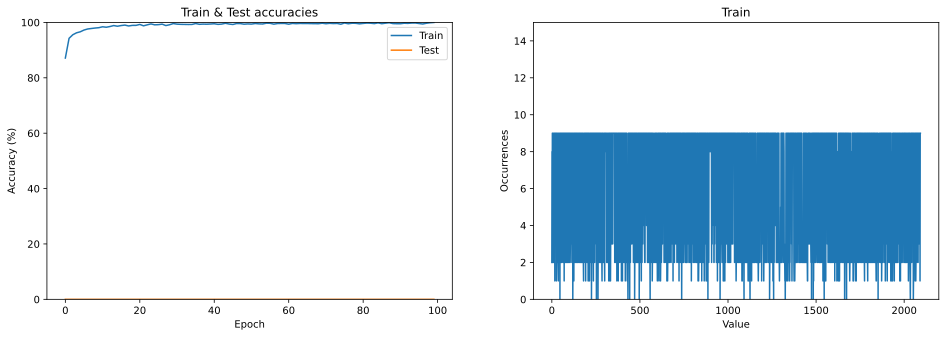

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(accuracy_experiments["train_accuracy_experiment"], label='Train')
ax[0].plot(accuracy_experiments["test_accuracy_experiment"], label='Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_ylim([0, 100])
ax[0].set_title('Train & Test accuracies')
ax[0].legend()

ax[1].plot(guesses, label='Test results')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Occurrences')
ax[1].set_ylim([0, 15])
ax[1].set_title('Train')
# ax[1].legend()

plt.show()